avail devices:
/dev/cu.debug-console - n/a
/dev/cu.wlan-debug - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbserial-DK0DLCLR - FT230X Basic UART
/dev/cu.usbmodem14201 - IOUSBHostDevice
0F5DD

Set jog step: 160.07 deg

homed device: b'1POFFFFFFFE\r\n'


100%|███████████████████████████████████████████| 90/90 [01:36<00:00,  1.07s/it]


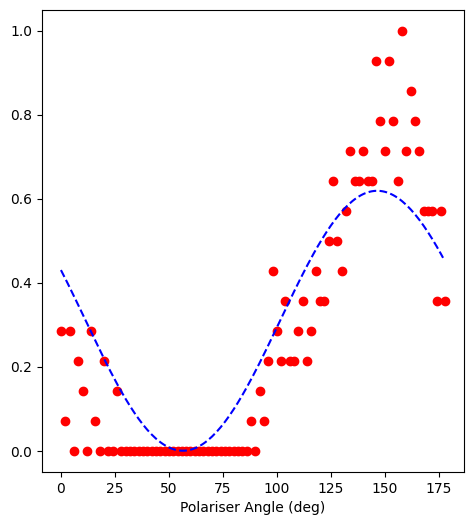

In [25]:
import numpy as np
import serial
import time
import os
import threading
from tqdm import tqdm
import serial.tools.list_ports
from scipy.optimize import curve_fit
import sys
import matplotlib.pyplot as plt

flagStop = False

# ALL INSTRUCTIONS CAN BE FOUND HERE, FROM THE MANUAL:
# https://www.thorlabs.com/Software/Elliptec/Communications_Protocol/ELLx%20modules%20protocol%20manual_Issue7.pdf

print("avail devices:")
for port in serial.tools.list_ports.comports():
    print(port)

# CONSTANTS ##########

POLARISER_DEV = "/dev/cu.usbserial-DK0DLCLR"
BIFRINGENCE_DEV = "/dev/ttyUSB0"
ARDUINO_DEV = "/dev/cu.usbmodem14201"

######################

def MT_ExitPoll():
    while True:
        inp = input()
        if inp.strip() == 'q':
            flagStop = True
            break

def Degrees2Hex(deg):
    pulses = int(deg / 360 * 143360)  # 143360 = 360 deg
    hexPulses = hex(pulses).upper()  # Hex characters have to be capitals
    return hexPulses[2:]

def Serial2Deg(serialString):
    pos = round((int(serialString.strip()[3:], 16) / 143360 * 360), 2)
    return pos

def OpenELLDevice(device):
    dev = serial.Serial(device, baudrate=9600, stopbits=serial.STOPBITS_ONE, timeout=1)
    dev.reset_input_buffer()
    dev.flushInput()
    dev.flushOutput()
    return dev

def OpenArduinoDevice(device):
    dev = serial.Serial(device, baudrate=9600)
    dev.reset_input_buffer()
    dev.flushInput()
    dev.flushOutput()
    return dev

def ELL_SetJog(degrees, device):
    jogStepSize = str(Degrees2Hex(degrees))
    if len(jogStepSize) < 4:
        jogStepSize = jogStepSize.zfill(4)
    # 1. serial instruction to set step size
    writeString = '1sj0000' + str(jogStepSize)
    device.write(writeString.encode('utf-8'))
    time.sleep(0.1)
    if device.in_waiting > 0:
        serialString = device.readline().decode('ascii')
        print(serialString)  # any messages back
    # 2. check its set
    device.write(("1gj" + "\n").encode('utf-8'))
    time.sleep(0.1)
    if device.in_waiting > 0:
        serialString = device.readline().decode('ascii')
        print('Set jog step: ' + str(round((int(serialString.strip()[3:], 16) / 143360 * 360), 2)) + ' deg\n')

def ELL_ResetHome(device):
    device.reset_input_buffer()
    device.write(b'1r -50\n')
    time.sleep(0.3)
    device.write(b'1ho\n')
    time.sleep(0.3)
    t0 = time.time()
    reply = b''
    while time.time() - t0 < 3:  # 3s timeout
        if device.in_waiting:
            reply += device.read(device.in_waiting)
            if b'PO' in reply or b'OK' in reply:
                print("homed device:", reply)
                break
        time.sleep(0.05)
    else:
        print("timeout occurred while homing ELL!", reply)

def ELL_RotateSingle(device, verbose=True):
    device.write(('1fw' + '\n').encode('utf-8'))
    time.sleep(0.05)  # 50 ms delay for motor
    if device.in_waiting > 0 and verbose:
        serialString = device.readline().decode('ascii')
        pos0 = round(Serial2Deg(serialString))
        if pos0 > 143360:
            pos0 = 0
        print('Current position of linear polariser = ' + str(pos0) + ' deg\n')

# rotate device and generate angles to power received readings.
def ELL_Rotate(device, ard_device, startDegree, endDegree, degreeStep, verbose=True):
    global flagStop
    ELL_SetJog(degreeStep, device)
    angles = np.arange(startDegree, endDegree, degreeStep)
    degCur = startDegree
    ELL_ResetHome(device)
    powerReadings = []
    timeReadings = []
    for idx in tqdm(angles):
        ard_device.write('pol'.encode())  # poll data
        pol = ard_device.readline().decode('ascii')
        powerReadings.append(float(pol.strip()))
        timeReadings.append(time.time_ns())
        ELL_RotateSingle(device, verbose)

    return angles, powerReadings, timeReadings

# plot the data from a rotation sequence. pass in the model function to plot against (must take in theta, p1, p2 and p3)
def MakePlot(ModelProc, angles, powers, saveDir):
    powers = powers / np.nanmax(powers)
    plt.close('all')
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121)
    plt.plot(angles, powers, 'ro')
    plt.xlabel('Polariser Angle (deg)')
    popt, pcov = curve_fit(ModelProc, angles, powers, bounds=([-0, -0, 0], [2, 2, np.pi]))
    Emax, Emin, alpha = popt
    fittingAngles = np.arange(np.nanmin(angles), np.nanmax(angles), 1)
    plt.plot(fittingAngles, model_f(fittingAngles, Emax, Emin, alpha), '--b')
    plt.savefig(saveDir + '/DataPlot.png')
    data_out = np.column_stack((angles, powers))
    np.savetxt(saveDir + '/Data.csv', data_out, delimiter=',',
               header='angles' + ',' + ','.join([f'y_{i}' for i in range(len(powers))]))

def model_f(theta, p1, p2, p3):
    degrees = np.pi / 180
    return (p1 * np.cos(theta * degrees - p3)) ** 2 + (p2 * np.sin(theta * degrees - p3)) ** 2

####

# perform experiment data retrieval
def AsyncRun():
    polariser = OpenELLDevice(POLARISER_DEV)
    arduino = OpenArduinoDevice(ARDUINO_DEV)
    angs, pows, _times = ELL_Rotate(polariser, arduino, 0, 180, 2, False)
    MakePlot(model_f, angs, pows, "/users/lucas/desktop/physics/year 3/dissert 1/dat/sugar2/blue-405")

    # ELL_Rotate(polariser, arduino, 0, 360, 10)


# kickoff     
# bgthread = threading.Thread(target=AsyncRun)
# bgthread.start()
# MT_ExitPoll()
AsyncRun()
